In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy import stats

In [3]:
run = 100

# ---------------------------
# Allocate arrays (Y1 side and Y2 side)
# ---------------------------
WD_QRGMM_Y1 = np.zeros(run); WD_CWGAN_Y1 = np.zeros(run); WD_Diff_Y1 = np.zeros(run); WD_Rect_Y1 = np.zeros(run)
KS_QRGMM_Y1 = np.zeros(run); KS_CWGAN_Y1 = np.zeros(run); KS_Diff_Y1 = np.zeros(run); KS_Rect_Y1 = np.zeros(run)

WD_QRGMM_Y2 = np.zeros(run); WD_CWGAN_Y2 = np.zeros(run); WD_Diff_Y2 = np.zeros(run); WD_Rect_Y2 = np.zeros(run)
KS_QRGMM_Y2 = np.zeros(run); KS_CWGAN_Y2 = np.zeros(run); KS_Diff_Y2 = np.zeros(run); KS_Rect_Y2 = np.zeros(run)

# ---------------------------
# Loop over runs and compute WD / KS
# Truth:
#   ./data/testdata1/testdata1_{r+1}.csv  -> F is column 5 (index 4)
#   ./data/testdata2/testdata2_{r+1}.csv  -> F is column 5 (index 4)
# Generated:
#   QRGMM outputtest1/outputtest2: single column -> index 0
#   CWGAN/Diff/Rect outputtest1/outputtest2: full DF -> F is column 5 (index 4)
# ---------------------------
for runi in range(run):
    # Truth
    test1 = pd.read_csv(f'./data/testdata1/testdata1_{runi+1}.csv', header=None)
    test2 = pd.read_csv(f'./data/testdata2/testdata2_{runi+1}.csv', header=None)
    y1_true = test1.iloc[:, 4]
    y2_true = test2.iloc[:, 4]

    # QRGMM (single column)
    qrgmm1 = pd.read_csv(f'./data/QRGMMoutputtest1/QRGMMoutputtest1_{runi+1}.csv', header=None).iloc[:, 0]
    qrgmm2 = pd.read_csv(f'./data/QRGMMoutputtest2/QRGMMoutputtest2_{runi+1}.csv', header=None).iloc[:, 0]

    # CWGAN / Diffusion / RectFlow (full DF, take column F = index 4)
    cwgan1 = pd.read_csv(f'./data/CWGANoutputtest1/CWGANoutputtest1_{runi+1}.csv').iloc[:, 4]
    cwgan2 = pd.read_csv(f'./data/CWGANoutputtest2/CWGANoutputtest2_{runi+1}.csv').iloc[:, 4]

    diff1  = pd.read_csv(f'./data/Diffusionoutputtest1/Diffusionoutputtest1_{runi+1}.csv').iloc[:, 4]
    diff2  = pd.read_csv(f'./data/Diffusionoutputtest2/Diffusionoutputtest2_{runi+1}.csv').iloc[:, 4]

    rect1  = pd.read_csv(f'./data/RectFlowoutputtest1/RectFlowoutputtest1_{runi+1}.csv').iloc[:, 4]
    rect2  = pd.read_csv(f'./data/RectFlowoutputtest2/RectFlowoutputtest2_{runi+1}.csv').iloc[:, 4]

    # ---------- Y1: WD / KS ----------
    WD_QRGMM_Y1[runi] = wasserstein_distance(qrgmm1, y1_true)
    WD_CWGAN_Y1[runi] = wasserstein_distance(cwgan1, y1_true)
    WD_Diff_Y1[runi]  = wasserstein_distance(diff1,  y1_true)
    WD_Rect_Y1[runi]  = wasserstein_distance(rect1,  y1_true)

    KS_QRGMM_Y1[runi], _ = stats.kstest(qrgmm1, y1_true)
    KS_CWGAN_Y1[runi], _ = stats.kstest(cwgan1, y1_true)
    KS_Diff_Y1[runi],  _ = stats.kstest(diff1,  y1_true)
    KS_Rect_Y1[runi],  _ = stats.kstest(rect1,  y1_true)

    # ---------- Y2: WD / KS ----------
    WD_QRGMM_Y2[runi] = wasserstein_distance(qrgmm2, y2_true)
    WD_CWGAN_Y2[runi] = wasserstein_distance(cwgan2, y2_true)
    WD_Diff_Y2[runi]  = wasserstein_distance(diff2,  y2_true)
    WD_Rect_Y2[runi]  = wasserstein_distance(rect2,  y2_true)

    KS_QRGMM_Y2[runi], _ = stats.kstest(qrgmm2, y2_true)
    KS_CWGAN_Y2[runi], _ = stats.kstest(cwgan2, y2_true)
    KS_Diff_Y2[runi],  _ = stats.kstest(diff2,  y2_true)
    KS_Rect_Y2[runi],  _ = stats.kstest(rect2,  y2_true)

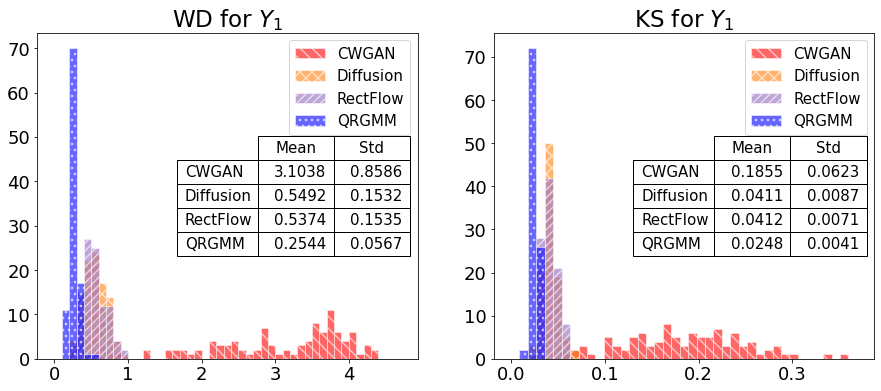

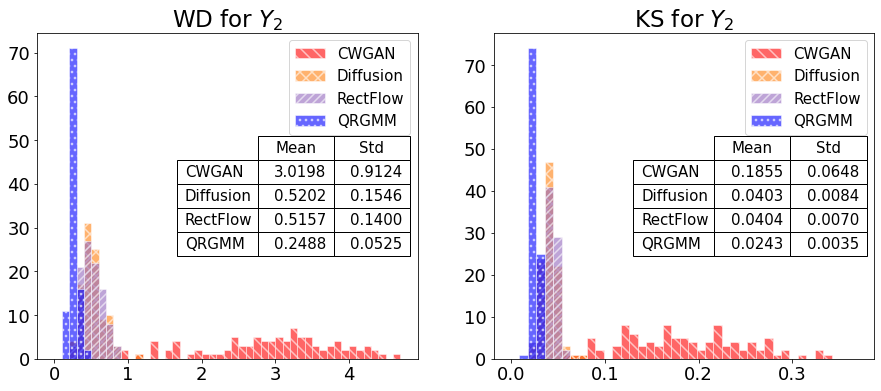

In [4]:
# ---------------------------
# Plot helper 
# ---------------------------
def plot_wdks_with_table_template(
    WD_dict, KS_dict, title_suffix, outpath,
    bins1=np.arange(0, 4.8, 0.10),
    bins2=np.arange(0, 0.37, 0.009),
):
    plt.rcParams['hatch.linewidth'] = 1.5
    # plt.rcParams['hatch.color'] = 'k'

    fig, a = plt.subplots(1, 2, figsize=(15, 6))

    order = [
        ("CWGAN",     "red",        "\\\\"),
        ("Diffusion", "tab:orange", "xx"),
        ("RectFlow",  "tab:purple", "///"),
        ("QRGMM",     "blue",       ".."),
    ]

    # ========================= WD hist =========================
    for name, color, hatch in order:
        a[0].hist(
            WD_dict[name], bins=bins1, density=False,
            color=color, alpha=0.6, label=name,
            edgecolor='w', hatch=hatch, linewidth=0.8
        )

    a[0].legend(fontsize=15)
    a[0].tick_params(labelsize=18)
    a[0].set_title(f"WD for ${title_suffix}$", fontsize=23)

    col_labels = ['Mean', 'Std']
    row_labels = [name for name, _, _ in order]
    table_vals = [
        ["{:.4f}".format(np.mean(WD_dict[name])),
         "{:.4f}".format(np.std(WD_dict[name], ddof=1))]
        for name, _, _ in order
    ]

    my_table = a[0].table(
        cellText=table_vals,
        colWidths=[0.1] * 2,
        rowLabels=row_labels,
        colLabels=col_labels,
        edges='closed',
        loc='center right'
    )
    my_table.auto_set_font_size(False)
    my_table.set_fontsize(15)
    my_table.scale(2, 2)

    # ========================= KS hist =========================
    for name, color, hatch in order:
        a[1].hist(
            KS_dict[name], bins=bins2, density=False,
            color=color, alpha=0.6, label=name,
            edgecolor='w', hatch=hatch, linewidth=0.8
        )

    a[1].legend(fontsize=15)
    a[1].tick_params(labelsize=18)
    a[1].set_title(f"KS for ${title_suffix}$", fontsize=23)

    table_vals = [
        ["{:.4f}".format(np.mean(KS_dict[name])),
         "{:.4f}".format(np.std(KS_dict[name], ddof=1))]
        for name, _, _ in order
    ]

    my_table = a[1].table(
        cellText=table_vals,
        colWidths=[0.1] * 2,
        rowLabels=row_labels,
        colLabels=col_labels,
        edges='closed',
        loc='center right'
    )
    my_table.auto_set_font_size(False)
    my_table.set_fontsize(15)
    my_table.scale(2, 2)

    os.makedirs("./plot", exist_ok=True)
    fig.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()


# ---------------------------
# Make Plots for Y1 / Y2 
# ---------------------------
WD_Y1 = {"QRGMM": WD_QRGMM_Y1, "CWGAN": WD_CWGAN_Y1, "Diffusion": WD_Diff_Y1, "RectFlow": WD_Rect_Y1}
KS_Y1 = {"QRGMM": KS_QRGMM_Y1, "CWGAN": KS_CWGAN_Y1, "Diffusion": KS_Diff_Y1, "RectFlow": KS_Rect_Y1}
plot_wdks_with_table_template(
    WD_Y1, KS_Y1,
    title_suffix="Y_1",
    outpath="./plot/WDKS_test1_withtable_EC.png"
)

WD_Y2 = {"QRGMM": WD_QRGMM_Y2, "CWGAN": WD_CWGAN_Y2, "Diffusion": WD_Diff_Y2, "RectFlow": WD_Rect_Y2}
KS_Y2 = {"QRGMM": KS_QRGMM_Y2, "CWGAN": KS_CWGAN_Y2, "Diffusion": KS_Diff_Y2, "RectFlow": KS_Rect_Y2}
plot_wdks_with_table_template(
    WD_Y2, KS_Y2,
    title_suffix="Y_2",
    outpath="./plot/WDKS_test2_withtable_EC.png"
)